In [1]:
# import urllib.request

# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", 
#                            filename="./data/ratings_train.txt")
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", 
#                            filename="./data/ratings_test.txt")

In [ ]:
# 데이터 전처리
    # 1. 비어 있는 리뷰 처리
    # 2. 한글외의 문자는 Nan 처리
    # 3. 같은 리뷰 제거

#  학습 데이터와 테스트 데이터로 정형화
    # 4. x 와 y로 분리
    # 5. 단어로 토큰 
    # 6. 패딩
    
# 7. 모델 구조 설계
# 8. 모델 실행

In [1]:
# 자연어 처리를 위한 keras 라이브러리 선언
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from attention import Attention

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

In [ ]:
print(train_data['document'].isnull().sum())  # 리뷰가 없는 자료 확인 -  학습데이터
train_data = train_data.dropna()               # 리뷰가 없는 행 삭제
print(train_data['document'].isnull().sum())   # 리뷰 없는 행 제거 확인

print(test_data['document'].isnull().sum())  # 리뷰가 없는 자료 확인 - 테스트 데이터
test_data = test_data.dropna()               # 리뷰가 없는 행 삭제
print(test_data['document'].isnull().sum())   # 리뷰 없는 행 제거 확인

In [ ]:
print("중복된 리뷰 갯수 : ", train_data['document'].duplicated().sum())  #  중복된 리뷰 갯수 확인
train_data = train_data.drop_duplicates(subset=['document'])
print("중복된 리뷰 갯수 : ", train_data['document'].duplicated().sum())  #  중복된 리뷰 갯수 확인

print("중복된 리뷰 갯수 : ", test_data['document'].duplicated().sum())  #  중복된 리뷰 갯수 확인
test_data = test_data.drop_duplicates(subset=['document'])
print("중복된 리뷰 갯수 : ", test_data['document'].duplicated().sum())  #  중복된 리뷰 갯수 확인

In [17]:
# 한글과 space 외의 문자 : 정규표현식을 사용하여  ''  로 대체
train_data['document'] = train_data['document'].str.replace(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 " "]', '', regex=True)
train_data['document'] = train_data['document'].replace('', np.nan) #  '' -> np.nan 으로 대체
train_data.dropna(inplace=True)

# test_data 처리
test_data['document'] = test_data['document'].str.replace(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 " "]', '', regex=True)
test_data['document'] = test_data['document'].replace('', np.nan) #  '' -> np.nan 으로 대체
test_data.dropna(inplace=True)

In [20]:
# 최종 자료 확인
print(train_data.head(2))
print()
print(test_data.head(2))

        id                    document  label
0  9976970           아 더빙 진짜 짜증나네요 목소리      0
1  3819312  흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나      1

        id                          document  label
0  6270596                               굳 ㅋ      1
2  8544678  뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아      0


In [21]:
# 학습 데이터를 x 와 label(y) 로 분리
x_train = train_data['document']
y_train = train_data['label']

# 테스트 데이터를 x 와 label(y) 로 분리
x_test = test_data['document']
y_test = test_data['label']

In [31]:
# 학습 데이터가 자연어이므로 단어로 토큰화 -> padding
token_train = Tokenizer()
token_train.fit_on_texts(x_train)
train_padded = pad_sequences(token_train.texts_to_sequences(x_train), maxlen=20)

# 테스트 데이터 토큰화 -> padding
token_test = Tokenizer()
token_test.fit_on_texts(x_test)
test_padded = pad_sequences(token_test.texts_to_sequences(x_test), maxlen=20)

In [37]:
word_size = len(token_train.word_index) + 1

In [39]:
#   모델 설계
model = Sequential()
model.add(Embedding(word_size,20, input_length=20))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(50, return_sequences=True))
model.add(Attention())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 20)            5990360   
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            6464      
                                                                 
 dropout_1 (Dropout)         (None, 16, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 4, 50)             23000     
                                                                 
 attention_1 (Attention)     (None, 128)               15300     
                                                      

In [40]:
#  모델 실행 옵션
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3)

# 모델 실행
history = model.fit(train_padded, y_train, batch_size=20, epochs=100, 
                    validation_split=0.25,
                   callbacks=[early_stopping])

Epoch 1/100
5468/5468 [==============================] - 351s 64ms/step - loss: 0.4545 - accuracy: 0.7711 - val_loss: 0.4044 - val_accuracy: 0.8069
Epoch 2/100
5468/5468 [==============================] - 352s 64ms/step - loss: 0.1618 - accuracy: 0.9404 - val_loss: 0.4841 - val_accuracy: 0.7912
Epoch 3/100
5468/5468 [==============================] - 343s 63ms/step - loss: 0.0663 - accuracy: 0.9777 - val_loss: 0.5977 - val_accuracy: 0.7839
Epoch 4/100
5468/5468 [==============================] - 339s 62ms/step - loss: 0.0356 - accuracy: 0.9882 - val_loss: 0.6428 - val_accuracy: 0.7810


In [41]:
# 테스트 데이터의 정확도 출력
print("Test Accuracy : ", model.evaluate(test_padded, y_test)[1])

1532/1532 [==============================] - 3s 2ms/step - loss: 2.0413 - accuracy: 0.4989
Test Accuracy :  0.4988876283168793


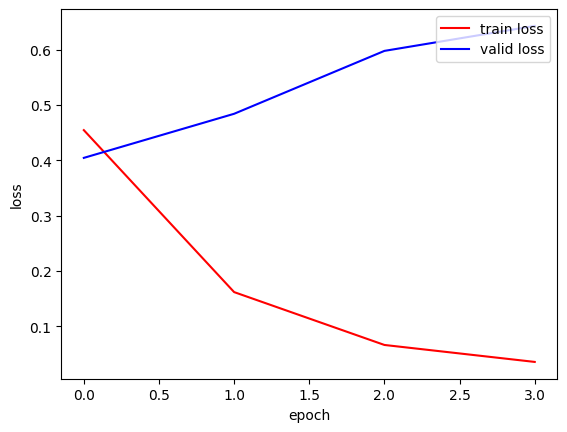

In [42]:
#  학습셋과 테스트셋의 오차를 그래프로 확인
y_loss = history.history['loss']
y_vloss = history.history['val_loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, c='red', label='train loss')
plt.plot(x_len, y_vloss, c='blue', label='valid loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()